In [1]:
library(tidyverse)
library(repr)
library(infer)
library(janitor)
library(tidymodels)
library(cowplot)
library(rsample)   
library(recipes)
options(repr.matrix.max.rows = 6)
source('cleanup.R')

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test


── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ modeldata    1.4.0     ✔ workflows    1.1.4
✔ parsnip      1.2.1     ✔ workflowsets 1.0.1
✔ recipes      1.1.0     ✔ yardstick    1.3.1

── Conflicts ────────────────────────────────

## Research Question

Can a player’s total cumulative play-time (`total_minutes`)
and average session length (`mean_session`)
predict whether they subscribe to the game’s newsletter?

**Response variable:** `newsletter_subscribed`  
(0 = no, 1 = yes)  
**Predictors:** `total_minutes`, `mean_session`

In [2]:
players <- read_csv("Data/players.csv")
sessions <- read_csv("Data/sessions.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
print("Players Data")
head(players)
tail(players)
dim(players)

print("Sessions Data")
head(sessions)
tail(sessions)
dim(sessions)

[1] "Players Data"


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Amateur,TRUE,644fe4200c19a73768b3fa598afcbd0948f7557925b7f17166285da23af31cc6,0.0,Rhys,Male,20
Amateur,TRUE,b6e9e593b9ec51c5e335457341c324c34a2239531e1890b93ca52ac1dc76b08f,0.0,Bailey,Female,17
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


[1] 196   7

[1] "Sessions Data"


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
b622593d2ef8b337dc554acb307d04a88114f2bf453b18fb5d2c80052aeb2319,28/08/2024 23:31,29/08/2024 00:15,1.72489e+12,1.72489e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,10/05/2024 23:01,10/05/2024 23:07,1.71538e+12,1.71538e+12
7a4686586d290c67179275c7c3dfb4ea02f4d317d9ee0e2cee98baa27877a875,01/07/2024 04:08,01/07/2024 04:19,1.71981e+12,1.71981e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12


[1] 1535    5

**What is the dataset about?**  
This data comes from a UBC Minecraft research server.  
- `players.csv` has one row per player (demographics, total play time, newsletter flag).  
- `sessions.csv` logs each play session’s start/end timestamps so we can derive session lengths.

**How many variables?**  
- `players.csv`: 7 columns  
- `sessions.csv`: 5 columns

**How many observations?**  
- `players.csv`: 196 rows  
- `sessions.csv`: 1535 rows

In [4]:
sessions <- sessions

sessions <- sessions |>
  mutate(
    start_ts        = dmy_hm(start_time), 
    end_ts          = dmy_hm(end_time),
    session_minutes = as.numeric(difftime(end_ts, start_ts, units="mins"))
  )


In [5]:
names(sessions)
head(sessions$session_minutes)

[1] "hashedEmail"         "start_time"          "end_time"           
[4] "original_start_time" "original_end_time"   "start_ts"           
[7] "end_ts"              "session_minutes"

[1]  12  13  23  36  11 122

In [6]:
session_agg <- sessions |>
  group_by(hashedEmail) |>
  summarise(
    mean_session = mean(session_minutes, na.rm = TRUE),
    n_sessions   = n()
  )

In [7]:
head(session_agg)

hashedEmail,mean_session,n_sessions
<chr>,<dbl>,<int>
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,53.00000,2
060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,30.00000,1
0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,11.00000,1
0d4d71be33e2bc7266ee4983002bd930f69d304288a8663529c875f40f1750f3,32.15385,13
0d70dd9cac34d646c810b1846fe6a85b9e288a76f5dcab9c1ff1a0e7ca200b3a,35.00000,2
11006065e9412650e99eea4a4aaaf0399bc338006f85e80cc82d18b49f0e2aa4,10.00000,1


In [8]:
players_clean <- players |>
  clean_names() |>
  rename(player_id = hashed_email) |>
  mutate(
    newsletter_subscribed = factor(
      subscribe,
      levels = c(FALSE, TRUE),
      labels = c("no", "yes")
    ),
    total_minutes = played_hours * 60
  ) |>
  select(player_id, newsletter_subscribed, total_minutes)

In [9]:
head(players_clean)

player_id,newsletter_subscribed,total_minutes
<chr>,<fct>,<dbl>
f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,yes,1818
f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,yes,228
b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,no,0
23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,yes,42
7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,yes,6
f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,yes,0


In [10]:
df <- players_clean |>
    left_join(
    session_agg,
    by = c("player_id" = "hashedEmail")
  ) |>
  drop_na(newsletter_subscribed, total_minutes, mean_session)

dim(df)
names(df)
head(df)


[1] 125   5

[1] "player_id"             "newsletter_subscribed" "total_minutes"        
[4] "mean_session"          "n_sessions"

player_id,newsletter_subscribed,total_minutes,mean_session,n_sessions
<chr>,<fct>,<dbl>,<dbl>,<int>
f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,yes,1818,74.77778,27
f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,yes,228,85.00000,3
b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,no,0,5.00000,1
23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,yes,42,50.00000,1
7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,yes,6,9.00000,1
1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,no,0,5.00000,1


In [11]:
table(df$newsletter_subscribed) |> as.data.frame()

Var1,Freq
<fct>,<int>
no,32
yes,93


**Outcome variable:** `newsletter_subscribed`  
- **Values:**  
  - 0 = no  
  - 1 = yes  
- **Observations:**  
  - 0 (no): 32  
  - 1 (yes): 93  

**Outcome variable:** `newsletter_subscribed`  
- **Levels:**  
  - “no”  → did not subscribe  
  - “yes” → did subscribe  
- **Counts (in `df`):**  
  - no : 32  
  - yes: 93  

> **Note:** We began with 196 players in `players.csv`, but after joining session data  
> and dropping missing cases, our modeling frame (`df`) has 125 players.


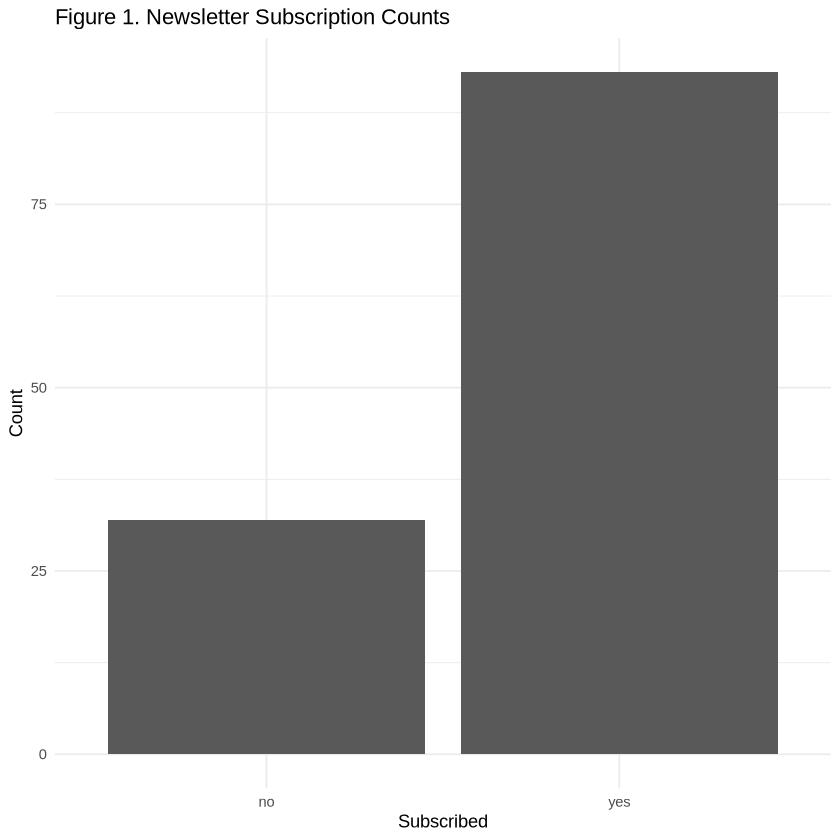

In [20]:
subscription_visual <- df |>
ggplot(aes(x = newsletter_subscribed)) +
    geom_bar() + labs(
    title = "Figure 1. Newsletter Subscription Counts",
    x     = "Subscribed",
    y     = "Count"
  ) + theme_minimal()

subscription_visual 

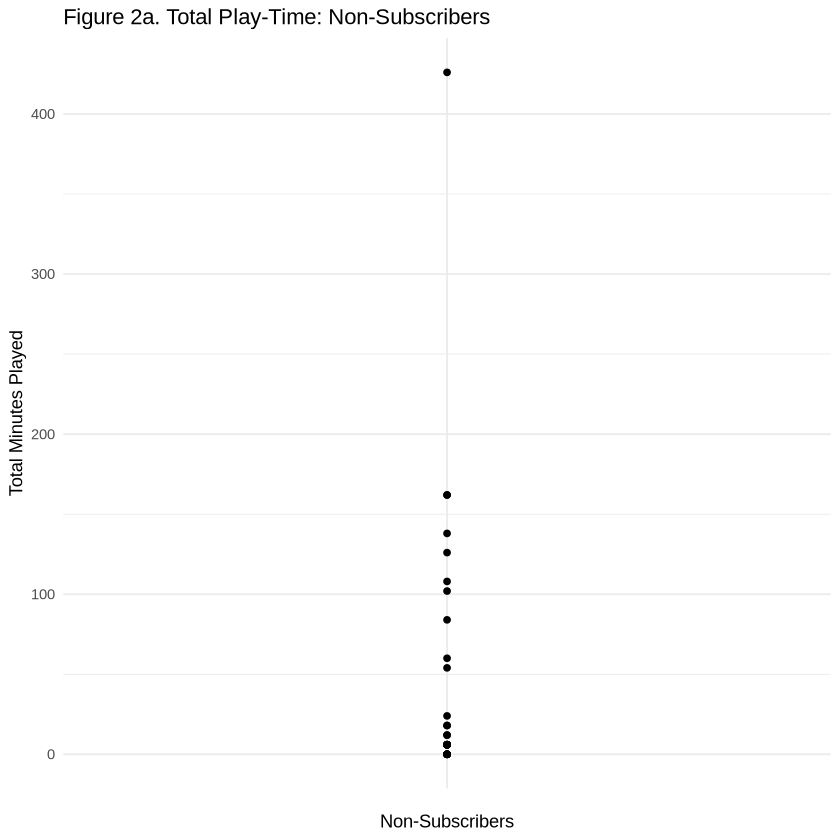

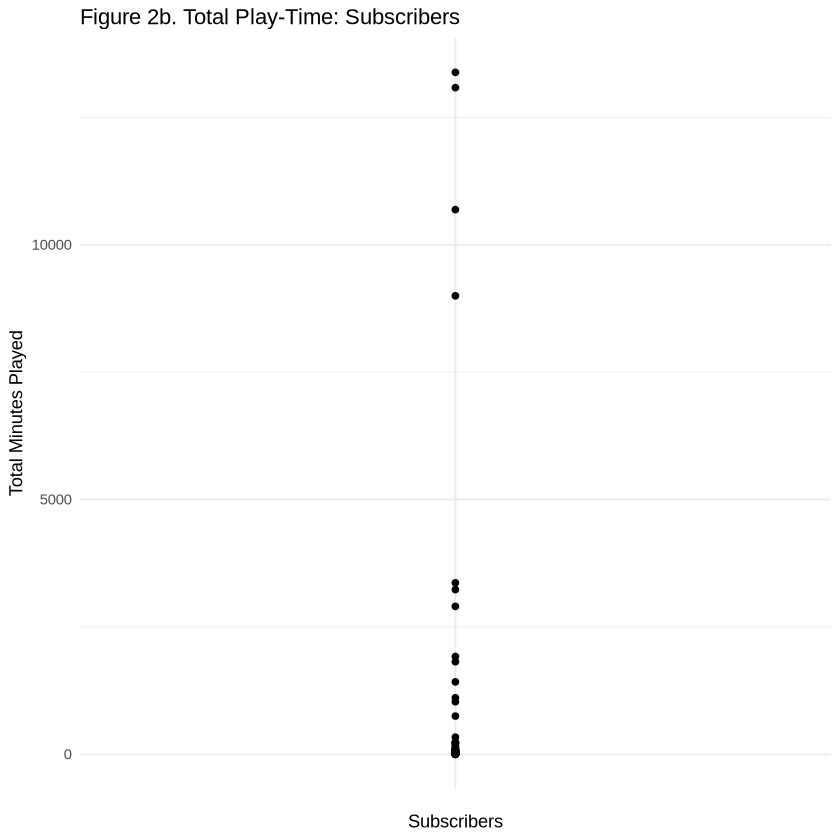

In [19]:
df_no <- df |> filter(newsletter_subscribed == "no")
df_yes <- df |> filter(newsletter_subscribed == "yes")

p0 <- ggplot(df_no, aes(x = "", y = total_minutes)) +
    geom_point() + labs(
    title = "Figure 2a. Total Play-Time: Non-Subscribers",
    x     = "Non-Subscribers",
    y     = "Total Minutes Played"
  ) + theme_minimal()

p1 <- ggplot(df_yes, aes(x = "", y = total_minutes)) +
    geom_point() + labs(
    title = "Figure 2b. Total Play-Time: Subscribers",
    x     = "Subscribers",
    y     = "Total Minutes Played"
  ) + theme_minimal()

p0
p1

**Figure 2a:** Distribution of total play-time among non-subscribers.  
**Figure 2b:** Distribution of total play-time among subscribers.

In [14]:
library(rsample)    # for initial_split()

set.seed(123)
split <- initial_split(df, prop = 0.8, strata = "newsletter_subscribed")
train <- training(split)
test <- testing(split)

In [15]:
library(recipes)

rec <- recipe(newsletter_subscribed ~ total_minutes + mean_session, data = train) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

In [16]:
knn_spec <- nearest_neighbor(neighbors = 5) |>
    set_engine("kknn") |>
    set_mode("classification")

In [21]:
knn_fit <- workflow() |>
  add_recipe(rec) |>
  add_model(knn_spec) |>
  fit(data = train)

In [27]:
pred_class <- predict(knn_fit, new_data = test, type = "class")

results <- bind_cols(test, pred_class)

table(
  Predicted = results$.pred_class,
  Actual    = results$newsletter_subscribed
)

results |>
  metrics(
    truth = newsletter_subscribed,
    estimate = .pred_class
  )

         Actual
Predicted no yes
      no   2   5
      yes  5  14

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.61538462
kap,binary,0.02255639


- **Why KNN?** Simple distance-based classifier.  
- **Preprocessing:** Center & scale via recipe so KNN distances aren’t dominated by scale.  
- **Stratified split:** Preserves class balance.  

In [18]:
source('cleanup.R')